# Detection of modified images or videos using Neural Networks

## Importing the libraries

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageChops, ImageFilter
import pandas as pd
import os
import io
import shutil
from kaggle.api.kaggle_api_extended import KaggleApi

import tensorflow as tf
from tensorflow import keras
from keras import backend as K
from keras.utils import to_categorical
from keras.models import Sequential, Model, load_model
from keras.optimizers import Adam, SGD
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Activation, Input, Lambda, Resizing, Rescaling, GlobalAveragePooling2D, RandomFlip, RandomRotation, RandomZoom, RandomCrop, RandomTranslation, RandomContrast
from keras.applications import ResNet50, MobileNet, MobileNetV2, VGG16, Xception
from keras.regularizers import l2
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, confusion_matrix
import itertools

#K.clear_session()
#tf.compat.v1.reset_default_graph()
#tf.compat.v1.enable_eager_execution()

## Downloading the dataset

In [2]:
URL = "sophatvathana/casia-dataset"
PATH_DATASET = './../dataset/'

def download_dataset():
    api = KaggleApi()
    api.authenticate()
    print("Downloading files...")
    api.dataset_download_files('sophatvathana/casia-dataset', path=PATH_DATASET, unzip=True)

    print("\rDownload complete.")


def clean_directory():
    print("Moving folder...")
    os.rename(PATH_DATASET+"CASIA2/Au", PATH_DATASET+"Au")
    os.rename(PATH_DATASET+"CASIA2/Tp", PATH_DATASET+"Tp")
    
    print("Cleaning directory...")
    shutil.rmtree(PATH_DATASET+"casia")
    shutil.rmtree(PATH_DATASET+"CASIA1")
    shutil.rmtree(PATH_DATASET+"CASIA2")
    os.remove(PATH_DATASET+"Tp/Thumbs.db")
    os.remove(PATH_DATASET+"Au/Thumbs.db")
    print("Cleaning complete.")

def remove_images():
    print("Removing images...")
    for i in range(1, 4):
        os.remove(PATH_DATASET+"Au/Au ("+str(i)+").jpg")
        os.remove(PATH_DATASET+"Tp/Tp ("+str(i)+").jpg")
    print("Removing complete.")

In [3]:
if not os.path.exists(PATH_DATASET+"Au"):
    download_dataset()
    clean_directory()
else:
    print("Dataset already Downloaded.")

Dataset already Downloaded.


In [4]:
REAL_IMAGE_PATH = '../dataset/Au'
FAKE_IMAGE_PATH = "../dataset/Tp"
IMG_SIZE = (128, 128)
CLASS = ['real', 'fake']

## Loading the dataset

In [5]:
cabezera_au = "category", "image", "class"
df_au = pd.DataFrame(columns=cabezera_au)

cabezera_tp = "category", "image", "region", "class"
df_tp = pd.DataFrame(columns=cabezera_tp)

for idx, file in enumerate(os.listdir(REAL_IMAGE_PATH)):
    img_path = os.path.join(REAL_IMAGE_PATH, file)
    category = file.split("_")

    df_au = pd.concat([df_au, pd.DataFrame([[category[1], img_path, CLASS[0]]], columns=cabezera_au)], ignore_index=True)

df_au = df_au[df_au.category != "txt"]
df_au = df_au[df_au.category != "ind"]
df_au = df_au.groupby('category').head(600)

for file in os.listdir(FAKE_IMAGE_PATH):
    #convert image to np array
    img_path = os.path.join(FAKE_IMAGE_PATH, file)

    category = file.split("_")
    category[5] = category[5][:3]
    df_tp = pd.concat([df_tp, pd.DataFrame([[category[5], img_path, category[1], CLASS[1]]], columns=cabezera_tp)], ignore_index=True)

df_tp = df_tp[df_tp.category != "txt"]
df_tp = df_tp[df_tp.category != "ind"]
df_tp = df_tp.groupby(['category', 'region']).head(300)
df_tp = df_tp.drop(columns=['region'])

df = pd.concat([df_au, df_tp], ignore_index=True)
df = df.sample(frac=1).reset_index(drop=True)

df.head()


,category,image,class
0,arc,../dataset/Tp\Tp_S_NNN_S_B_arc20022_arc20022_0...,fake
1,pla,../dataset/Au\Au_pla_30138.jpg,real
2,pla,../dataset/Tp\Tp_S_CNN_M_N_pla10116_pla10116_1...,fake
3,arc,../dataset/Tp\Tp_S_NNN_S_N_arc00095_arc00095_1...,fake
4,nat,../dataset/Au\Au_nat_30054.jpg,real


## Creating Preprocessing Function

In [6]:
def ela(image, quality=90):
    # Comprimir y descomprimir la imagen
    _, buffer = cv2.imencode('.jpg', image, [cv2.IMWRITE_JPEG_QUALITY, quality])
    compressed_image = cv2.imdecode(np.frombuffer(buffer, np.uint8), cv2.IMREAD_COLOR)

    #convert compressed_image uint8 to float32
    compressed_image = compressed_image.astype(np.float32)

    diff = 15 * cv2.absdiff(image, compressed_image)
    
    return diff

def ela_v2(orig_img, quality=99):
    _, buffer = cv2.imencode('.jpg', orig_img, [cv2.IMWRITE_JPEG_QUALITY, quality])
    compressed_img = cv2.imdecode(np.frombuffer(buffer, np.uint8), cv2.IMREAD_COLOR)

    orig_img = orig_img.astype(np.uint8)

    diff = 15 * cv2.absdiff(orig_img, compressed_img)
    gray_diff = cv2.cvtColor(diff, cv2.COLOR_BGR2GRAY)

    # Aplicar umbralización para convertir en una imagen binaria
    threshold_value, binary_image = cv2.threshold(gray_diff, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Multiplicar la imagen binaria por la imagen de diferencia original para resaltar los píxeles falsos
    diff_highlighted = cv2.bitwise_and(diff, diff, mask=binary_image)

    # Aplicar filtrado Gaussiano para reducir el ruido
    diff_filtered = cv2.GaussianBlur(diff_highlighted, (5, 5), 0)

    return diff_filtered

def preprocess_image(img):
    image = ela_v2(img)
    return tf.convert_to_tensor(image)

## Creating Model

In [7]:
def normalitation(image):
    pass
    

def flip_horizontal(image):
    return tf.image.flip_left_right(image)

def flip_vertical(image):
    return tf.image.flip_up_down(image)

def data_augmentation(x, y):
    x_aug = []
    y_aug = []

    for i in range(len(x)):
        x_aug.append(x[i])
        y_aug.append(y[i])
        x_aug.append(flip_horizontal(x[i]))
        y_aug.append(y[i])
        x_aug.append(flip_vertical(x[i]))
        y_aug.append(y[i])

    return x_aug, y_aug

In [8]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

In [9]:
batch_size = 32

In [10]:
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_image,
    rotation_range=10,
    horizontal_flip=True,
    vertical_flip=True,
    validation_split=0.2,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_image,
)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=df_train,
    directory=None,
    x_col="image",
    y_col="class",
    subset="training",
    batch_size=batch_size,
    seed=42,
    shuffle=True,
    class_mode="binary",
    target_size=IMG_SIZE
)

val_generator = train_datagen.flow_from_dataframe(
    dataframe=df_train,
    directory=None,
    x_col="image",
    y_col="class",
    subset="validation",
    batch_size=batch_size,
    seed=42,
    shuffle=True,
    class_mode="binary",
    target_size=IMG_SIZE
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=df_test,
    directory=None,
    x_col="image",
    y_col="class",
    batch_size=batch_size,
    shuffle=False,
    class_mode="binary",
    target_size=IMG_SIZE
)

Found 4997 validated image filenames belonging to 2 classes.
Found 1249 validated image filenames belonging to 2 classes.
Found 1562 validated image filenames belonging to 2 classes.


### Creating the checkpoints

In [11]:
metrics = [
    tf.keras.metrics.BinaryAccuracy(name='binary_accuracy'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall'),
    tf.keras.metrics.AUC(name='auc'),
    tf.keras.metrics.AUC(name='prc', curve='PR')
]

early_stopping = EarlyStopping(
    monitor='val_loss', 
    min_delta=0, 
    patience=10, 
    verbose=0, 
    mode='auto', 
    baseline=None, 
    restore_best_weights=False
)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)


model_chekpoint = ModelCheckpoint(
    filepath='./../model/checkpoints', 
    monitor='val_loss', 
    verbose=0, 
    save_best_only=True,
    save_weights_only=True, 
    mode='auto', 
    save_freq='epoch'
)

tensor_board = TensorBoard(
    log_dir='./../model/logs',
    histogram_freq=0,
    write_graph=True,
    write_images=False,
    update_freq='epoch',
    profile_batch=2,
    embeddings_freq=0,
    embeddings_metadata=None
)

callbacks = [early_stopping, model_chekpoint, tensor_board, reduce_lr]
optimizer = Adam(1e-5)
loss = keras.losses.BinaryCrossentropy()

In [12]:
base_model = Xception(weights='imagenet', include_top=False, input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))

# Congelar las capas de la base
base_model.trainable = False

data_augmentation = Sequential([
    RandomFlip("horizontal_and_vertical"), 
    RandomRotation(0.2),
])

# Definir la capa de preprocesamiento
preprocessing_layer = Sequential([
    Resizing(IMG_SIZE[0], IMG_SIZE[1]),
    Rescaling(1./127.5, offset=-1),
])

# Agregar la capa de preprocesamiento a la entrada
inputs = Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
x = preprocessing_layer(inputs)
x = data_augmentation(x)

# Agregar capas adicionales en la parte superior del modelo pre-entrenado
x = base_model(x)
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.2)(x)
outputs = Dense(1, activation='sigmoid')(x)

# Definir el modelo completo
model = Model(inputs, outputs)

In [13]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 128, 128, 3)       0         
                                                                 
 sequential (Sequential)     (None, 128, 128, 3)       0         
                                                                 
 xception (Functional)       (None, 4, 4, 2048)        20861480  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1024)              2098176   
                                                             

### Training the model

In [14]:
initial_epochs = 20
fine_tune_epochs = 30
total_epochs =  initial_epochs + fine_tune_epochs

In [15]:
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
history = model.fit(
    train_generator,
    epochs=initial_epochs, 
    batch_size=batch_size, 
    validation_data=val_generator,
    callbacks=callbacks
)

Epoch 1/20
157/157 [==============================] - 63s 344ms/step - loss: 0.6908 - binary_accuracy: 0.5113 - precision: 0.5566 - recall: 0.3079 - auc: 0.5626 - prc: 0.5531 - val_loss: 0.6860 - val_binary_accuracy: 0.5532 - val_precision: 0.6169 - val_recall: 0.4891 - val_auc: 0.5925 - val_prc: 0.6121 - lr: 1.0000e-05
Epoch 2/20
157/157 [==============================] - 40s 256ms/step - loss: 0.6847 - binary_accuracy: 0.5675 - precision: 0.5894 - recall: 0.5620 - auc: 0.5866 - prc: 0.5763 - val_loss: 0.6811 - val_binary_accuracy: 0.5781 - val_precision: 0.6076 - val_recall: 0.6511 - val_auc: 0.5975 - val_prc: 0.6195 - lr: 1.0000e-05
Epoch 3/20
157/157 [==============================] - 37s 237ms/step - loss: 0.6803 - binary_accuracy: 0.5866 - precision: 0.5996 - recall: 0.6226 - auc: 0.6004 - prc: 0.5931 - val_loss: 0.6793 - val_binary_accuracy: 0.5949 - val_precision: 0.6126 - val_recall: 0.7109 - val_auc: 0.5996 - val_prc: 0.6206 - lr: 1.0000e-05
Epoch 4/20
157/157 [==============

In [16]:
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  132


In [17]:
base_model.trainable = True

fine_tune_at = -10

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

In [18]:
optimizer = Adam(1e-5)

In [19]:
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
history_fine = model.fit(
    train_generator,
    epochs=total_epochs, 
    initial_epoch=history.epoch[-1],
    batch_size=batch_size, 
    validation_data=val_generator,
    callbacks=callbacks
)

Epoch 20/50
157/157 [==============================] - 36s 209ms/step - loss: 0.6581 - binary_accuracy: 0.6158 - precision: 0.6101 - recall: 0.7495 - auc: 0.6526 - prc: 0.6513 - val_loss: 0.6758 - val_binary_accuracy: 0.6205 - val_precision: 0.6337 - val_recall: 0.7299 - val_auc: 0.6427 - val_prc: 0.6754 - lr: 1.0000e-05
Epoch 21/50
157/157 [==============================] - 31s 198ms/step - loss: 0.6511 - binary_accuracy: 0.6212 - precision: 0.6234 - recall: 0.6906 - auc: 0.6698 - prc: 0.6711 - val_loss: 0.6732 - val_binary_accuracy: 0.6005 - val_precision: 0.6120 - val_recall: 0.7416 - val_auc: 0.6419 - val_prc: 0.6814 - lr: 1.0000e-05
Epoch 22/50
157/157 [==============================] - 33s 213ms/step - loss: 0.6505 - binary_accuracy: 0.6238 - precision: 0.6284 - recall: 0.6810 - auc: 0.6688 - prc: 0.6727 - val_loss: 0.6487 - val_binary_accuracy: 0.6173 - val_precision: 0.6329 - val_recall: 0.7197 - val_auc: 0.6572 - val_prc: 0.6861 - lr: 1.0000e-05
Epoch 23/50
157/157 [==========

### Showing the results

In [20]:
acc = history.history['binary_accuracy'] + history_fine.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy'] + history_fine.history['val_binary_accuracy']

loss = history.history['loss'] + history_fine.history['loss']
val_loss = history.history['val_loss'] + history_fine.history['val_loss']

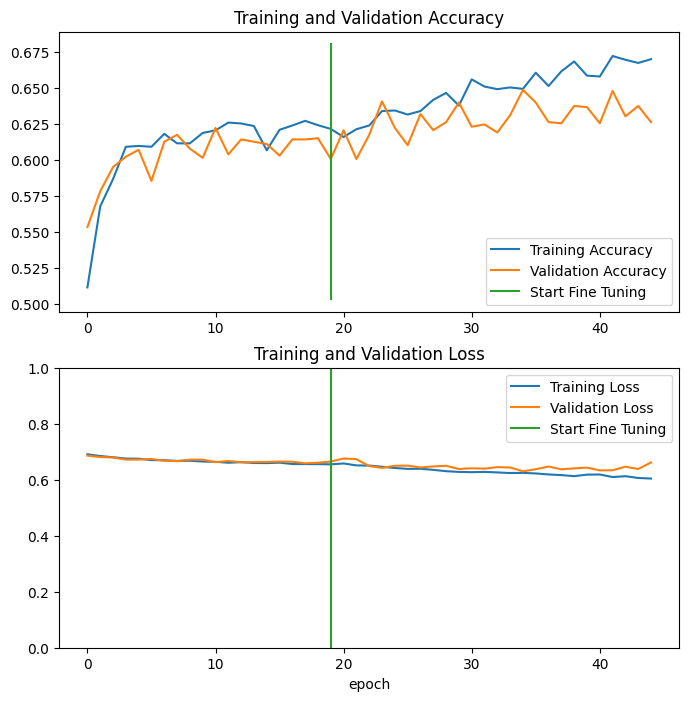

In [21]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### Evaluating the model

In [22]:
model.evaluate(test_generator)

49/49 [==============================] - 6s 125ms/step - loss: 0.6438 - binary_accuracy: 0.6325 - precision: 0.7029 - recall: 0.6396 - auc: 0.6788 - prc: 0.7347


[0.6438077688217163,
 0.6325224041938782,
 0.7028985619544983,
 0.6395604610443115,
 0.6788233518600464,
 0.7346827387809753]

In [ ]:
model.save('./../model/detect_manipulated_images_model_resNet50.h5')